## Job Reports 2022

[<img src='./companies.png' alt='wanjikureports twitter img' width=200 height=300 />](https://twitter.com/WanjikuReports/status/1473929269319553026)

Notes:
- [basics](https://shkspr.mobi/blog/2020/08/omg-twitter-release-an-official-conversations-api/)
- [python](https://towardsdatascience.com/mining-replies-to-tweets-a-walkthrough-9a936602c4d6)

### Goal
We are performing an analysis of desired jobs come 2022 from replies generated by a tweet from the account [`@WanjikuReports`](https://twitter.com/WanjikuReports/status/1473929269319553026) 

<!-- ![wanjikureports twitter img](./companies.png) -->
### Table of Contents
1. Text cleaning and extraction
1. Wordcloud
1. Sentiment Analysis

In [1]:
import pandas as pd
import os, json
import pandas as pd
import numpy as np
import glob
import re
import sys

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
np.set_printoptions(threshold=sys.maxsize)


In [2]:
companies = {
    '1': 'Safaricom', 
    '2': 'EABL', 
    '3': 'UN, United Nations', 
    '4': 'KRA', 
    '5': 'KenGen', 
    '6': 'KPC, Kenya Pipeline Company', 
    '7': 'Coca cola', 
    '8':'Deloitte', 
    '9': 'Unilever', 
    '10': 'Kplc, Kenya Power', 
    '11': 'Google', 
    '12': 'KPA, Kenya Ports Authority',
    '13': 'KCB, Kenya Commercial Bank', 
    '14': 'Microsoft', 
    '15': 'Bidco', 
    '16': 'RMS, Royal Media Services', 
    '17': 'KEMRI, Kenya Medical Research Institute',
    '18': 'Amref'
}

Export tweets (json format)

In [3]:

# f = open('./dayta/1-json.json')
arr = []
path_to_json = './dayta/'
json_pattern = os.path.join(path_to_json, '*.json')
file_list = glob.glob(json_pattern)

# print(file_list)

for file in file_list:
    with open(file) as f:
        temp = json.load(f)
        for line in temp['data']:
            arr.append(line)



df = pd.DataFrame(data=arr)
# save to csv
df.to_csv('./out/collated.csv')

df = df[['text', 'created_at']]

# df.head(100)

#### Text Cleaning and Extraction

##### Pre-processing

In [4]:
txt_lower = df['text'].str.lower()
txt_l_cln = txt_lower.str.replace("\@wanjikureports", "") #replace wanjiku mentions
txt_l_cln2 = txt_l_cln.str.replace("(\n*\d\.)", '') #replace ordered listings e.g. 1., 2. etc
narr = txt_l_cln2.to_numpy()

**Pseudocode**

Each listitem in list
- Remove all stop words
- Split all words/numbers
- Check whether word in company list, if in list add to output var -> use eigenvalues, check for closeness of word
- check each # with company list key, add value to output list

In [5]:
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = list(get_stop_words('en'))       #About 900 stopwords
nltk_words = list(stopwords.words('english')) #About 150 stopwords
stop_words.extend(nltk_words)

In [6]:
from difflib import SequenceMatcher
import jellyfish


def similar(a, b):
    return jellyfish.jaro_distance(a, b)  # prob threshhold set at 0.75
    # return SequenceMatcher(None, a, b).ratio()


def returnFromNumeric(numstr):
    if 1 <= int(numstr) <= 18:
        splt = companies[numstr].split(',')
        return splt[0]

# https://stackoverflow.com/questions/51217909/removing-all-emojis-from-text
def replaceEmoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F1F2-\U0001F1F4"  # Macau flag
                               u"\U0001F1E6-\U0001F1FF"  # flags
                               u"\U0001F600-\U0001F64F"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U0001F1F2"
                               u"\U0001F1F4"
                               u"\U0001F620"
                               u"\u200d"
                               u"\u2640-\u2642"
                               "]+", flags=re.UNICODE)


    return emoji_pattern.sub(r'', text)


def returnFromStr(thestr):
    output = None

    for val in companies.values():
        splt = val.split(',')

        selected = splt[0]
        prob = similar(thestr, splt[0].lower())

        if prob < 0.75 and len(splt) > 1:
            # selected = splt[1]
            prob = similar(thestr, splt[1].lower())

        if prob >= .75:
            output = selected

    return output


In [7]:
similar('kenya_ports', 'Kenya Ports Authority'.lower())

# thevar = 'KPA, Kenya pipes'.split(',')
# print(thevar[0])
# if (len(thevar) > 1):
#     print(thevar[1])

0.7950937950937952

In [11]:
output_arr=[]
test = narr[:5]

for i,txt in enumerate(narr):
    if i not in [908, 1073]:
        tokens = word_tokenize(txt)
        print(i)
        for token in tokens:
            if token.isnumeric():
                output_arr.append(returnFromNumeric(token))
            else:
                output_arr.append(returnFromStr(token))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# tt= narr[908]
# nt = replaceEmoji(tt)
# print(nt)

# word_tokenize(nt)
# # narr[908]

In [12]:
finalarr = [txt for txt in output_arr if txt is not None]

finalarr

['KPA',
 'KPC',
 'Coca cola',
 'Amref',
 'Amref',
 'KPA',
 'EABL',
 'Google',
 'Microsoft',
 'Deloitte',
 'Unilever',
 'KPA',
 'KCB',
 'KCB',
 'Amref',
 'Google',
 'UN',
 'Google',
 'UN',
 'Kplc',
 'Google',
 'Safaricom',
 'EABL',
 'KPA',
 'UN',
 'KPC',
 'Unilever',
 'Safaricom',
 'KPC',
 'UN',
 'EABL',
 'Safaricom',
 'EABL',
 'Kplc',
 'Bidco',
 'Coca cola',
 'KRA',
 'Google',
 'Microsoft',
 'Amref',
 'EABL',
 'Amref',
 'KPA',
 'KenGen',
 'RMS',
 'UN',
 'Unilever',
 'Kplc',
 'EABL',
 'EABL',
 'EABL',
 'Unilever',
 'KCB',
 'Amref',
 'Safaricom',
 'Amref',
 'Safaricom',
 'KPA',
 'KenGen',
 'EABL',
 'Safaricom',
 'Coca cola',
 'KCB',
 'Google',
 'Microsoft',
 'Safaricom',
 'UN',
 'KenGen',
 'Unilever',
 'Unilever',
 'UN',
 'Deloitte',
 'Google',
 'Deloitte',
 'KRA',
 'Deloitte',
 'EABL',
 'Coca cola',
 'Safaricom',
 'KPA',
 'Unilever',
 'Safaricom',
 'KPA',
 'Google',
 'EABL',
 'UN',
 'Amref',
 'Unilever',
 'UN',
 'Google',
 'UN',
 'Microsoft',
 'Unilever',
 'Amref',
 'Microsoft',
 'Micro

In [13]:
corpus = "; ".join(finalarr)
corpus

'KPA; KPC; Coca cola; Amref; Amref; KPA; EABL; Google; Microsoft; Deloitte; Unilever; KPA; KCB; KCB; Amref; Google; UN; Google; UN; Kplc; Google; Safaricom; EABL; KPA; UN; KPC; Unilever; Safaricom; KPC; UN; EABL; Safaricom; EABL; Kplc; Bidco; Coca cola; KRA; Google; Microsoft; Amref; EABL; Amref; KPA; KenGen; RMS; UN; Unilever; Kplc; EABL; EABL; EABL; Unilever; KCB; Amref; Safaricom; Amref; Safaricom; KPA; KenGen; EABL; Safaricom; Coca cola; KCB; Google; Microsoft; Safaricom; UN; KenGen; Unilever; Unilever; UN; Deloitte; Google; Deloitte; KRA; Deloitte; EABL; Coca cola; Safaricom; KPA; Unilever; Safaricom; KPA; Google; EABL; UN; Amref; Unilever; UN; Google; UN; Microsoft; Unilever; Amref; Microsoft; Microsoft; UN; KenGen; UN; Google; KPA; KenGen; Google; KCB; EABL; Bidco; KPA; EABL; UN; Amref; Google; Amref; Microsoft; UN; Bidco; UN; Safaricom; KenGen; UN; UN; KCB; KRA; KRA; KPC; Unilever; Safaricom; Google; Microsoft; Coca cola; KCB; Amref; Amref; KenGen; EABL; KenGen; KenGen; UN; EAB

In [14]:
cols = ['Companies']
df_out = pd.DataFrame(finalarr, columns = cols )
df_grp = df_out.groupby(cols).size().reset_index(name='Count')

In [15]:
df_grp.sort_values(by='Count', ascending=False)

,Companies,Count
4,EABL,243
17,Unilever,192
0,Amref,189
16,UN,171
5,Google,168
15,Safaricom,160
11,KenGen,146
8,KPA,106
12,Kplc,100
13,Microsoft,98


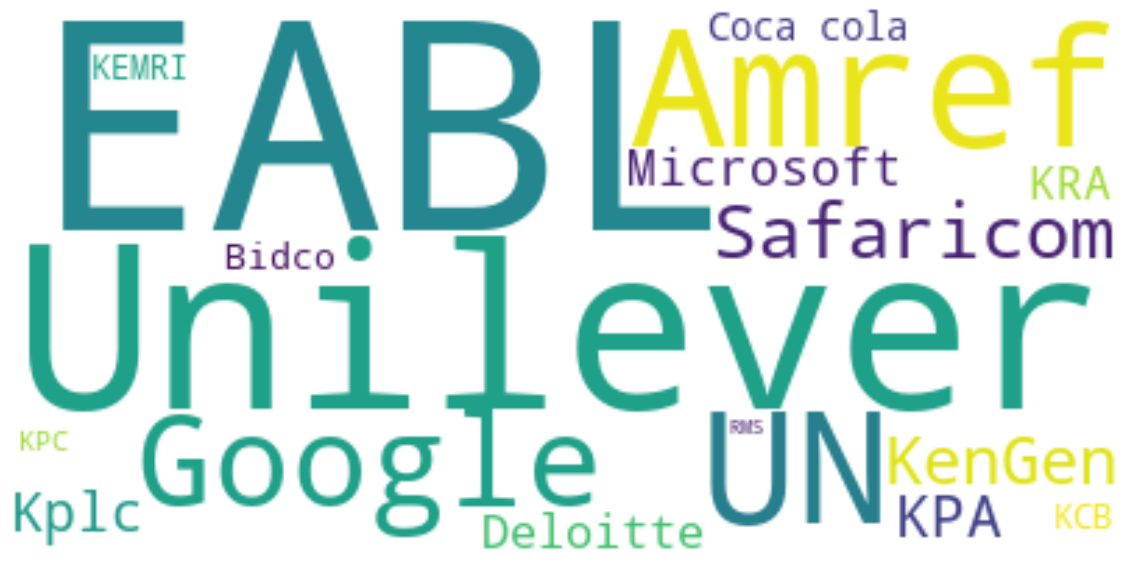

In [16]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt

word_could_dict=Counter(finalarr)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_could_dict) #.generate(corpus) #.generate_from_frequencies(word_could_dict)    
#Post processing
#ii. plot word cloud model
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Notes
Its important to note changes to metrics the last 3 days - AMref moved from 2nd to 3rd etc
Note that this data points change over time i.e. These interpretations are time-bound and decay over time
Important to keep updating this data


Save to csv

In [17]:
df_grp.sort_values(by='Count', ascending=False).to_csv('./out/sortedout.csv')

#### Sentiment Analysis
> This section touches on analysing bigrams; graphical representation of relationship between words
- Expunge all stopwords
- Expunge all mentions - regex
- Obtain bigrams

>> [Sentiment Analysis Reference](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/)